# 8. **Post-Processing**

[
    <svg style="color: rgb(53, 145, 243)" width="20" height="20"  viewBox="0 0 22 10" xmlns="http://www.w3.org/2000/svg"><g fill="currentColor" transform="translate(1 1)"><path d="m.5 9.5 9-9 9 9" fill="currentColor"></path><path d="m2.5 7.5v8c0 .5522847.44771525 1 1 1h3c.55228475 0 1-.4477153 1-1v-4c0-.5522847.44771525-1 1-1h2c.5522847 0 1 .4477153 1 1v4c0 .5522847.4477153 1 1 1h3c.5522847 0 1-.4477153 1-1v-8" fill="#3591f3"></path></g></svg>
](https://scottlevie97.github.io/pythonFVSolidMechanics)[<svg style="color: rgb(53, 145, 243);" xmlns="http://www.w3.org/2000/svg" width="20" height="20" fill="currentColor" class="bi bi-arrow-left-circle-fill" viewBox="0 0 16 16"> <path d="M8 0a8 8 0 1 0 0 16A8 8 0 0 0 8 0zm3.5 7.5a.5.5 0 0 1 0 1H5.707l2.147 2.146a.5.5 
0 0 1-.708.708l-3-3a.5.5 0 0 1 0-.708l3-3a.5.5 0 1 1 .708.708L5.707 7.5H11.5z" fill="#3591f3"></path> </svg> **Notebook 7** ](https://nbviewer.org/github/scottlevie97/pythonFVSolidMechanics/blob/new-release/lesson_notebooks/_07_Time_Loop.ipynb?flush_cache=true)

---


Now that we have a solution displacement field, we need to verify the results. We will look at three post-processing criteria for the cantilever beam test case. These are:

- Deflection of the beam tip
- Strain field
- Stress field

The beam deflection is probably the most useful as it can be compared to an analytical solution.


Before proceeding with post-processing we need to calculate the displacement values on the boundaries via extrapolation, as done in <code>boundaryCellTraction</code>:


## Boundary Displacements

Firstly we need to load the solution displacement field.


In [60]:
import numpy as np
path = open('./Solution/0/U.csv')
U = np.loadtxt(path, delimiter=",")


For each boundary, we assign displacements to the boundary faces. If the boundary condition is fixed displacement, this value is assigned. If the boundary condition is fixed traction, a linear extrapolation is used:


In [61]:
from ipynb.fs.defs._05_Fixed_Traction_BCs import boundaryCellTraction
from functions.setup import *


def addBoundaryDisplacements(U_field):

    # Add boundaries to displacement fields:

    # Initialise displacement vectors for internal cells and points on the boundary
    U_with_boundaries = np.zeros((ny+2, nx+2))

    # Reshape Field into displacement formation
    U_reshape = U_field[:, 0].reshape(ny, nx)
    U_reshape = np.flip(U_reshape, 0)
    U_with_boundaries[1:ny+1, 1:nx + 1] = U_reshape

    V_with_boundaries = np.zeros((ny+2, nx+2))
    V_reshape = U_field[:, 1].reshape(ny, nx)
    V_reshape = np.flip(V_reshape, 0)
    V_with_boundaries[1:ny+1, 1:nx + 1] = V_reshape

    linearExtrapolate = boundaryCellTraction.linearExtrapolate

    #### Traction ####

    # Bottom boundary:
    if BC_settings("b").traction:

        for i in np.arange(1, nx + 1):
            ycoord = ny+1
            U_with_boundaries[ycoord, i] = linearExtrapolate(
                U_with_boundaries[(ycoord-1), i], U_with_boundaries[(ycoord-2), i])
            V_with_boundaries[ycoord, i] = linearExtrapolate(
                V_with_boundaries[(ycoord-1), i], V_with_boundaries[(ycoord-2), i])

    # Top boundary:
    if BC_settings("t").traction:

        for i in np.arange(1, nx + 1):
            ycoord = 0
            U_with_boundaries[ycoord, i] = linearExtrapolate(
                U_with_boundaries[(ycoord+1), i], U_with_boundaries[(ycoord+2), i])
            V_with_boundaries[ycoord, i] = linearExtrapolate(
                V_with_boundaries[(ycoord+1), i], V_with_boundaries[(ycoord+2), i])

    # Right boundary:
    if BC_settings("r").traction:

        for i in np.arange(1, ny + 1):
            xcoord = nx+1
            U_with_boundaries[i, xcoord] = linearExtrapolate(
                U_with_boundaries[i, (xcoord-1)], U_with_boundaries[i, (xcoord-2)])
            V_with_boundaries[i, xcoord] = linearExtrapolate(
                V_with_boundaries[i, (xcoord-1)], V_with_boundaries[i, (xcoord-2)])

    # Left boundary:
    if BC_settings("l").traction:

        for i in np.arange(1, ny + 1):
            xcoord = 0
            U_with_boundaries[i, xcoord] = linearExtrapolate(
                U_with_boundaries[i, (xcoord+1)], U_with_boundaries[i, (xcoord+2)])
            V_with_boundaries[i, xcoord] = linearExtrapolate(
                V_with_boundaries[i, (xcoord+1)], V_with_boundaries[i, (xcoord+2)])

    ##### Fixed Displacement ####

    # Bottom boundary:
    if BC_settings("b").fixed_displacement:

        for i in np.arange(1, nx + 1):
            ycoord = ny+1
            U_with_boundaries[ycoord, i] = boundary_U("b", "x").BC
            V_with_boundaries[ycoord, i] = boundary_U("b", "y").BC

    # Top boundary:
    if BC_settings("t").fixed_displacement:

        for i in np.arange(1, nx + 1):
            ycoord = 0
            U_with_boundaries[ycoord, i] = boundary_U("t", "x").BC
            V_with_boundaries[ycoord, i] = boundary_U("t", "y").BC

    # Right boundary:
    if BC_settings("r").fixed_displacement:

        for i in np.arange(1, ny + 1):
            xcoord = nx+1
            U_with_boundaries[i, xcoord] = boundary_U("r", "x").BC
            V_with_boundaries[i, xcoord] = boundary_U("r", "y").BC

    # Left boundary:
    if BC_settings("l").fixed_displacement:

        for i in np.arange(1, ny + 1):
            xcoord = 0
            U_with_boundaries[i, xcoord] = boundary_U("l", "x").BC
            V_with_boundaries[i, xcoord] = boundary_U("l", "y").BC

    # Corners Extrapolation:

    # Bottom Left:
    xcoord = 0
    ycoord = ny+1
    U_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        U_with_boundaries[ycoord - 1, xcoord + 1], U_with_boundaries[ycoord - 2, xcoord + 2])
    V_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        V_with_boundaries[ycoord - 1, xcoord + 1], V_with_boundaries[ycoord - 2, xcoord + 2])

    # Bottom Right:
    xcoord = nx+1
    ycoord = ny+1
    U_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        U_with_boundaries[ycoord - 1, xcoord - 1], U_with_boundaries[ycoord - 2, xcoord - 2])
    V_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        V_with_boundaries[ycoord - 1, xcoord - 1], V_with_boundaries[ycoord - 2, xcoord - 2])

    # Top Left:
    xcoord = 0
    ycoord = 0
    U_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        U_with_boundaries[ycoord + 1, xcoord + 1], U_with_boundaries[ycoord + 2, xcoord + 2])
    V_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        V_with_boundaries[ycoord + 1, xcoord + 1], V_with_boundaries[ycoord + 2, xcoord + 2])

    # Top Right:
    xcoord = nx+1
    ycoord = 0
    U_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        U_with_boundaries[ycoord + 1, xcoord - 1], U_with_boundaries[ycoord + 2, xcoord - 2])
    V_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        V_with_boundaries[ycoord + 1, xcoord - 1], V_with_boundaries[ycoord + 2, xcoord - 2])

    return U_with_boundaries, V_with_boundaries


In [ ]:
def addBoundaryDisplacements_2(U_field):

    # Add boundaries to displacement fields:

    # Initialise displacement vectors for internal cells and points on the boundary
    U_with_boundaries = np.zeros((ny+2, nx+2))

    # Reshape Field into displacement formation
    U_reshape = U_field[:, 0].reshape(ny, nx)
    U_reshape = np.flip(U_reshape, 0)
    U_with_boundaries[1:ny+1, 1:nx + 1] = U_reshape

    V_with_boundaries = np.zeros((ny+2, nx+2))
    V_reshape = U_field[:, 1].reshape(ny, nx)
    V_reshape = np.flip(V_reshape, 0)
    V_with_boundaries[1:ny+1, 1:nx + 1] = V_reshape

    linearExtrapolate = boundaryCellTraction.linearExtrapolate

    #### Traction ####

    # Bottom boundary:
    if BC_settings("b").traction:

        for i in np.arange(1, nx + 1):
            ycoord = ny+1
            U_with_boundaries[ycoord, i] = linearExtrapolate(
                U_with_boundaries[(ycoord-1), i], U_with_boundaries[(ycoord-2), i])
            V_with_boundaries[ycoord, i] = linearExtrapolate(
                V_with_boundaries[(ycoord-1), i], V_with_boundaries[(ycoord-2), i])

    # Top boundary:
    if BC_settings("t").traction:

        for i in np.arange(1, nx + 1):
            ycoord = 0
            U_with_boundaries[ycoord, i] = linearExtrapolate(
                U_with_boundaries[(ycoord+1), i], U_with_boundaries[(ycoord+2), i])
            V_with_boundaries[ycoord, i] = linearExtrapolate(
                V_with_boundaries[(ycoord+1), i], V_with_boundaries[(ycoord+2), i])

    # Right boundary:
    if BC_settings("r").traction:

        for i in np.arange(1, ny + 1):
            xcoord = nx+1
            U_with_boundaries[i, xcoord] = linearExtrapolate(
                U_with_boundaries[i, (xcoord-1)], U_with_boundaries[i, (xcoord-2)])
            V_with_boundaries[i, xcoord] = linearExtrapolate(
                V_with_boundaries[i, (xcoord-1)], V_with_boundaries[i, (xcoord-2)])

    # Left boundary:
    if BC_settings("l").traction:

        for i in np.arange(1, ny + 1):
            xcoord = 0
            U_with_boundaries[i, xcoord] = linearExtrapolate(
                U_with_boundaries[i, (xcoord+1)], U_with_boundaries[i, (xcoord+2)])
            V_with_boundaries[i, xcoord] = linearExtrapolate(
                V_with_boundaries[i, (xcoord+1)], V_with_boundaries[i, (xcoord+2)])

    ##### Fixed Displacement ####

    # Bottom boundary:
    if BC_settings("b").fixed_displacement:

        for i in np.arange(1, nx + 1):
            ycoord = ny+1
            U_with_boundaries[ycoord, i] = boundary_U("b", "x").BC
            V_with_boundaries[ycoord, i] = boundary_U("b", "y").BC

    # Top boundary:
    if BC_settings("t").fixed_displacement:

        for i in np.arange(1, nx + 1):
            ycoord = 0
            U_with_boundaries[ycoord, i] = boundary_U("t", "x").BC
            V_with_boundaries[ycoord, i] = boundary_U("t", "y").BC

    # Right boundary:
    if BC_settings("r").fixed_displacement:

        for i in np.arange(1, ny + 1):
            xcoord = nx+1
            U_with_boundaries[i, xcoord] = boundary_U("r", "x").BC
            V_with_boundaries[i, xcoord] = boundary_U("r", "y").BC

    # Left boundary:
    if BC_settings("l").fixed_displacement:

        for i in np.arange(1, ny + 1):
            xcoord = 0
            U_with_boundaries[i, xcoord] = boundary_U("l", "x").BC
            V_with_boundaries[i, xcoord] = boundary_U("l", "y").BC

    # Corners Extrapolation:

    # Bottom Left:
    xcoord = 0
    ycoord = ny+1
    U_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        U_with_boundaries[ycoord - 1, xcoord + 1], U_with_boundaries[ycoord - 2, xcoord + 2])
    V_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        V_with_boundaries[ycoord - 1, xcoord + 1], V_with_boundaries[ycoord - 2, xcoord + 2])

    # Bottom Right:
    xcoord = nx+1
    ycoord = ny+1
    U_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        U_with_boundaries[ycoord - 1, xcoord - 1], U_with_boundaries[ycoord - 2, xcoord - 2])
    V_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        V_with_boundaries[ycoord - 1, xcoord - 1], V_with_boundaries[ycoord - 2, xcoord - 2])

    # Top Left:
    xcoord = 0
    ycoord = 0
    U_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        U_with_boundaries[ycoord + 1, xcoord + 1], U_with_boundaries[ycoord + 2, xcoord + 2])
    V_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        V_with_boundaries[ycoord + 1, xcoord + 1], V_with_boundaries[ycoord + 2, xcoord + 2])

    # Top Right:
    xcoord = nx+1
    ycoord = 0
    U_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        U_with_boundaries[ycoord + 1, xcoord - 1], U_with_boundaries[ycoord + 2, xcoord - 2])
    V_with_boundaries[ycoord, xcoord] = linearExtrapolate(
        V_with_boundaries[ycoord + 1, xcoord - 1], V_with_boundaries[ycoord + 2, xcoord - 2])

    return U_with_boundaries, V_with_boundaries


Applying <code>addBoundaryDisplacements</code> to U field:


In [62]:
u_with_boundaries, v_with_boundaries = addBoundaryDisplacements(U)


## Tip Deflection

The analytical solution for the the deflection $d$ of a slender cantilever beam is given by:

$$ d = \frac{PL^3}{3(\frac{E}{1-v^2})I} $$

Where $P = 0.1 $ MN is the applied load, $L = 2$ m is the length of the beam, and $ I = \frac{bh^3}{12} = \frac{0.1^3}{12}$ is the second moment of area of the beam about its bending axis.

$$ d = \cfrac{(-1\times{10}^6)(2)}{3 \left( \cfrac{200\mathrm{e}^9}{1-0.3^2} \right) \cfrac{0.1^3}{12}} = 0.01456 \space \textrm{m}$$

The deflection $d$ above is equivalent to the value of $v$ at the tip of the beam. So, lets plot the deflection in the $y$-direction ($v$) as a function of x.


In [63]:
# Initilise displacement vectors
x_displacement_vector = np.zeros(nx+2)
y_displacement_vector = np.zeros(ny+2)

# First value is equal to 0
x_displacement_vector[0] = 0
y_displacement_vector[0] = 0

# Last value is equal to Lx
x_displacement_vector[nx+1] = Lx
y_displacement_vector[ny+1] = Ly

# Cell centre values
x_displacement_vector[1:nx+1] = np.arange((Lx/nx)/2, Lx, Lx/nx)
y_displacement_vector[1:ny+1] = np.arange((Ly/ny)/2, Ly, Ly/ny)


In [64]:
# y-Deflection for y = 0
y_deflection = v_with_boundaries[0, :]


In [65]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.color"] = "grey"
plt.rcParams["grid.linewidth"] = 0.2
plt.rcParams["axes.grid"] = True

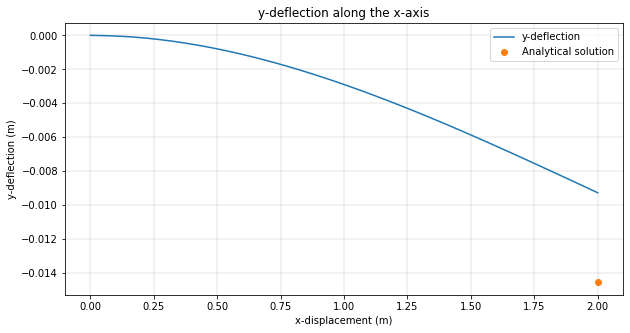

In [66]:
from matplotlib import pyplot as plt

plt.plot(x_displacement_vector, y_deflection,  label="y-deflection")
plt.scatter(2, -0.01456, label="Analytical solution", color="C1")
plt.xlabel("x-displacement (m)")
plt.ylabel("y-deflection (m)")
plt.title("y-deflection along the x-axis")
plt.legend()


## Partial Derivatives:

In order to display the strain and stress fields within the solution, the partial derivatives

$$ \frac{\partial u}{\partial x}, \frac{\partial v}{\partial y}, \frac{\partial u}{\partial y}, \frac{\partial v}{\partial x} $$

must be calculated. Previously this done at the face center. Now we will calculate this at the cell centre. 



In [67]:
class partialDisplacement:

    def __init__(self, u_with_boundaries, v_with_boundaries, nx, ny, dx, dy):

        ##### du/dx ####

        # Initialise field
        dudx = np.zeros([ny, nx])

        # j is y index
        for j in np.arange(0, np.size(dudx, 0)):
            # i is x index
            for i in np.arange(0, np.size(dudx, 1)):

                if (i == 0) | (i == np.size(dudx, 1) - 1):
                    denom = 1.5*dx
                else:
                    denom = 2*dx

                dudx[j, i] = (u_with_boundaries[j+1, i+2] -
                              u_with_boundaries[j+1, i])/denom

        self.dudx = dudx

        ##### dv/dy ####

        # Initialise field
        dvdy = np.zeros([ny, nx])

        # j is y index
        for j in np.arange(0, np.size(dvdy, 0)):
            # i is x index
            for i in np.arange(0, np.size(dvdy, 1)):

                if (j == 0) | (j == np.size(dvdy, 0) - 1):
                    denom = 1.5*dy
                else:
                    denom = 2*dy

                dvdy[j, i] = (v_with_boundaries[j, i+1] -
                              v_with_boundaries[j+2, i+1])/denom

        self.dvdy = dvdy

        ##### dv/dx ####

        # Initialise field
        dvdx = np.zeros([ny, nx])

        # j is y index
        for j in np.arange(0, np.size(dudx, 0)):
            # i is x index
            for i in np.arange(0, np.size(dvdx, 1)):

                if (i == 0) | (i == np.size(dvdx, 1) - 1):
                    denom = 1.5*dx
                else:
                    denom = 2*dx

                dvdx[j, i] = (v_with_boundaries[j+1, i+2] - v_with_boundaries[j+1, i])/denom

        self.dvdx = dvdx

        ##### du/dy ####

        # Initialise field
        dudy = np.zeros([ny, nx])

        # j is y index
        for j in np.arange(0, np.size(dudy, 0)):
            # i is x index
            for i in np.arange(0, np.size(dudy, 1)):

                if (j == 0) | (j == np.size(dudy, 0) - 1):
                    denom = 1.5*dy
                else:
                    denom = 2*dy

                dudy[j, i] = (u_with_boundaries[j, i+1] -
                              u_with_boundaries[j+2, i+1])/denom

        self.dudy = dudy


In [68]:
dudx = partialDisplacement(
    u_with_boundaries, v_with_boundaries, nx, ny, dx, dy).dudx
dvdy = partialDisplacement(
    u_with_boundaries, v_with_boundaries, nx, ny, dx, dy).dvdy
dvdx = partialDisplacement(
    u_with_boundaries, v_with_boundaries, nx, ny, dx, dy).dvdx
dudy = partialDisplacement(
    u_with_boundaries, v_with_boundaries, nx, ny, dx, dy).dudy


## Display Strain Field


Strain is a dimensionless property that describes a material's change in shape. Like stress, strain has both normal and shear components.

**Normal strain**: The change in length ($L$) divided by the original length:

$$ \frac{L_{new} - {L_{old}}}{{L_{old}}}

= \frac{\Delta L}{L} $$

**Shear strain**:  The change in deformation caused by a shearing force. Which is described as the change in angle between perpendicular lines. 


***NEEDS TO BE FINISHED***
https://www.sciencedirect.com/topics/earth-and-planetary-sciences/shear-strain

Similar to stress fields, there are two forms of strain,  

strain requires a tensor to describe it's various directions. 

$$\epsilon _{xx} = \frac{\partial u}{\partial x}$$
$$\epsilon _{yy} = \frac{\partial v}{\partial y}$$
$$\epsilon _{xy} = \dfrac{1}{2}\left(\dfrac{\partial v}{\partial x} + \dfrac{\partial u}{\partial y}\right)$$


In [69]:
epsilon_xx = dudx
epsilon_yy = dvdy
epsilon_xy = (1/2)*(dvdx + dudy)


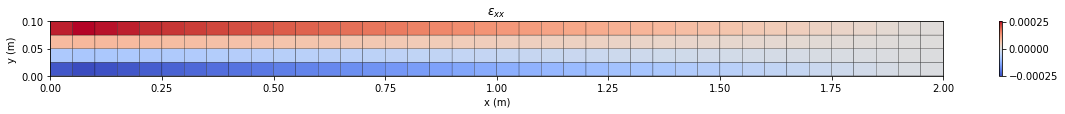

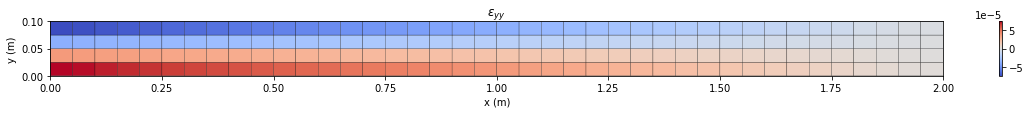

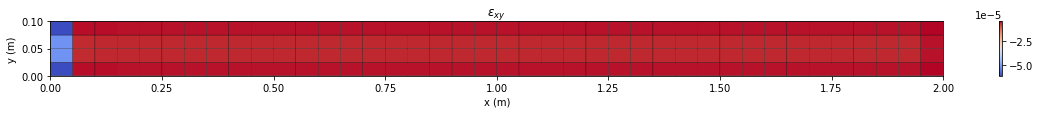

In [70]:
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.figsize"] = (Lx*10, Ly*10)

dispx, dispy = np.meshgrid(x_displacement_vector, y_displacement_vector)
dispx_cell = dispx[1:ny+1, 1:nx+1]
dispy_cell = dispy[1:ny+1, 1:nx+1]


plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.pcolor(dispx_cell, dispy_cell, np.flip(
    epsilon_xx, 0), edgecolors="k", cmap='coolwarm')
plt.title("$\epsilon _{xx}$")
plt.colorbar()
plt.show()

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.pcolor(dispx_cell, dispy_cell, np.flip(
    epsilon_yy, 0), edgecolors="k", cmap='coolwarm')
plt.title("$\epsilon _{yy}$")
plt.colorbar()
plt.show()

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.pcolor(dispx_cell, dispy_cell, np.flip(
    epsilon_xy, 0), edgecolors="k", cmap='coolwarm')
plt.title("$\epsilon _{xy}$")
plt.colorbar()
plt.show()


## Display Stress Fields


The cauchy stress tensor for linear elasticity as previously discussed in notebook 02 is given by:

$$
\boldsymbol{\sigma}
=
\begin{bmatrix}
\sigma_{xx}
&
\sigma_{xy}
\\
\sigma_{yx}
&
\sigma_{yy}
\end{bmatrix}
=
\begin{bmatrix}
(2\mu + \lambda)\dfrac{\partial u}{\partial x} + \lambda\dfrac{\partial v}{\partial y}
&
\mu \left( \dfrac{\partial v}{\partial x} + \dfrac{\partial u}{\partial y} \right)
\\
\mu \left( \dfrac{\partial v}{\partial x} + \dfrac{\partial u}{\partial y} \right)
&
(2\mu + \lambda)\dfrac{\partial v}{\partial y} + \lambda\dfrac{\partial u}{\partial x}
\end{bmatrix}
$$


In [71]:
sigma_xx = (2*mu_ + lambda_)*dudx + lambda_*dvdy
sigma_yy = (2*mu_ + lambda_)*dvdy + lambda_*dudx
sigma_xy = mu_*(dvdx + dudy)


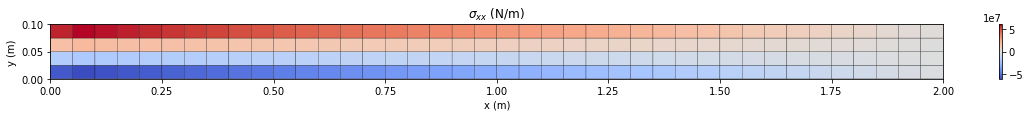

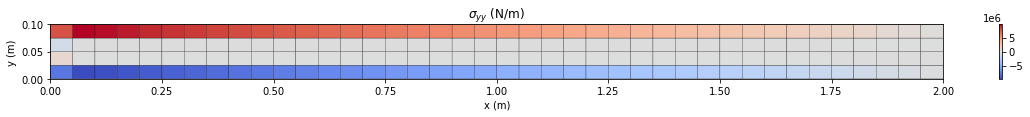

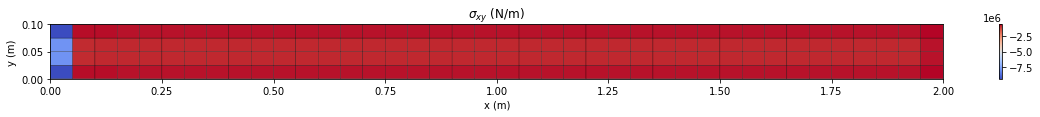

In [72]:
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.pcolor(dispx_cell, dispy_cell, np.flip(
    sigma_xx, 0), edgecolors="k", cmap='coolwarm')
plt.title("$\sigma _{xx}$ (N/m)")
plt.colorbar()
plt.show()

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.pcolor(dispx_cell, dispy_cell, np.flip(
    sigma_yy, 0), edgecolors="k", cmap='coolwarm')
plt.title("$\sigma _{yy}$ (N/m)")
plt.colorbar()
plt.show()

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.pcolor(dispx_cell, dispy_cell, np.flip(
    sigma_xy, 0), edgecolors="k", cmap='coolwarm')
plt.title("$\sigma _{xy}$ (N/m)")
plt.colorbar()
plt.show()


## Post-processing of a fine mesh

Let's repeat this for solution examples from finer meshes:


In [73]:
# Initialise array to store beam tip deflections
deflection_array = np.array([y_deflection[40]])
nx_array = np.array([40])


In [74]:
class postProcessing(partialDisplacement):

    plt.rcParams["figure.figsize"] = (10, 5)
    plt.rcParams["grid.linestyle"] = "-"
    plt.rcParams["grid.color"] = "grey"
    plt.rcParams["grid.linewidth"] = 0.2

    def __init__(self, path, nx, ny, Lx, Ly):

        dx = Lx/nx
        dy = Ly/ny

        file = open(path + "/U_with_boundaries.csv")
        self.u_with_boundaries = np.loadtxt(file, delimiter=",")
        file = open(path + "/V_with_boundaries.csv")
        self.v_with_boundaries = np.loadtxt(file, delimiter=",")

        self.dudx = partialDisplacement(
            self.u_with_boundaries, self.v_with_boundaries, nx, ny, dx, dy).dudx
        self.dvdy = partialDisplacement(
            self.u_with_boundaries, self.v_with_boundaries, nx, ny, dx, dy).dvdy
        self.dvdx = partialDisplacement(
            self.u_with_boundaries, self.v_with_boundaries, nx, ny, dx, dy).dvdx
        self.dudy = partialDisplacement(
            self.u_with_boundaries, self.v_with_boundaries, nx, ny, dx, dy).dudy

        self.x_displacement_vector = np.zeros(nx+2)
        self.y_displacement_vector = np.zeros(ny+2)

        # First value is equal to 0
        self.x_displacement_vector[0] = 0
        self.y_displacement_vector[0] = 0

        # Last value is equal to Lx
        self.x_displacement_vector[nx+1] = Lx
        self.y_displacement_vector[ny+1] = Ly

        # Cell centre values
        self.x_displacement_vector[1:nx+1] = np.arange((Lx/nx)/2, Lx, Lx/nx)
        self.y_displacement_vector[1:ny+1] = np.arange((Ly/ny)/2, Ly, Ly/ny)

        dispx, dispy = np.meshgrid(
            self.x_displacement_vector, self.y_displacement_vector)

        self.dispx_cell = dispx[1:ny+1, 1:nx+1]
        self.dispy_cell = dispy[1:ny+1, 1:nx+1]

    def yDeflection(self):

        y_deflection = self.v_with_boundaries[0, :]
        plt.rcParams["axes.grid"] = True
        plt.figure(figsize=(10, 5))
        plt.plot(self.x_displacement_vector,
                 y_deflection, label="y-deflection")
        plt.xlabel("$x$-direction (m)")
        plt.ylabel("y-deflection (m)")
        plt.scatter(2, -0.01456, label="Analytical solution", color="C1")
        plt.legend()
        plt.show()

    def epsilonGraph(self):

        color = "none"

        plt.rcParams["axes.grid"] = False
        plt.rcParams["figure.figsize"] = (Lx*10, Ly*10)

        epsilon_xx = self.dudx
        epsilon_yy = self.dvdy
        epsilon_xy = (1/2)*(self.dvdx + self.dudy)

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            epsilon_xx, 0), edgecolors=color, cmap='coolwarm')
        plt.title("$\epsilon _{xx}$")
        plt.colorbar()
        plt.show()

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            epsilon_yy, 0), edgecolors=color, cmap='coolwarm')
        plt.title("$\epsilon _{yy}$")
        plt.colorbar()
        plt.show()

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            epsilon_xy, 0), edgecolors=color, cmap='coolwarm')
        plt.title("$\epsilon _{xy}$")
        plt.colorbar()
        plt.show()

    def sigmaGraph(self, mu_, lambda_):

        color = "none"

        plt.rcParams["axes.grid"] = False
        plt.rcParams["figure.figsize"] = (Lx*10, Ly*10)

        sigma_xx = (2*mu_ + lambda_)*self.dudx + lambda_*self.dvdy
        sigma_yy = (2*mu_ + lambda_)*self.dvdy + lambda_*self.dudx
        sigma_xy = mu_*(self.dvdx + self.dudy)

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            sigma_xx, 0), edgecolors=color, cmap='coolwarm')
        plt.title("$\sigma _{xx}$ (N/m)")
        plt.colorbar()
        plt.show()

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            sigma_yy, 0), edgecolors=color, cmap='coolwarm')
        plt.title("$\sigma _{yy}$ (N/m)")
        plt.colorbar()
        plt.show()

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            sigma_xy, 0), edgecolors=color, cmap='coolwarm')
        plt.title("$\sigma _{xy}$ (N/m)")
        plt.colorbar()
        plt.show()

    def partialGraphs(self):

        color = "none"

        plt.rcParams["axes.grid"] = False
        plt.rcParams["figure.figsize"] = (Lx*10, Ly*10)

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            self.dudx, 0), edgecolors=color, cmap='coolwarm')
        plt.title("dudx")
        plt.colorbar()
        plt.show()

    def partialGraphs(self):

        color = "none"

        plt.rcParams["axes.grid"] = False
        plt.rcParams["figure.figsize"] = (Lx*10, Ly*10)

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            self.dvdy, 0), edgecolors=color, cmap='coolwarm')
        plt.title("dvdy")
        plt.colorbar()
        plt.show()
        
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            self.dudy, 0), edgecolors=color, cmap='coolwarm')
        plt.title("dudy")
        plt.colorbar()
        plt.show()
        
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            self.dvdx, 0), edgecolors=color, cmap='coolwarm')
        plt.title("dvdx")
        plt.colorbar()
        plt.show()

        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.pcolor(self.dispx_cell, self.dispy_cell, np.flip(
            self.dvdx + self.dudy , 0), edgecolors=color, cmap='coolwarm')
        plt.title("self.dvdx + self.dudy")
        plt.colorbar()
        plt.show()


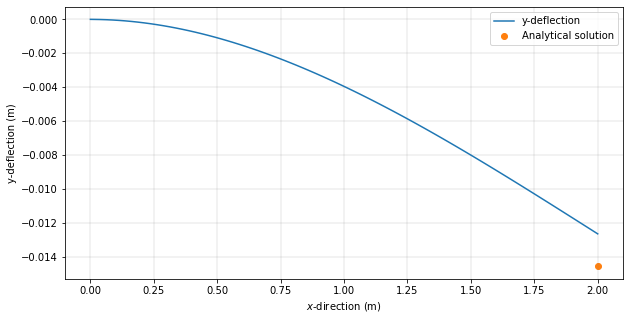

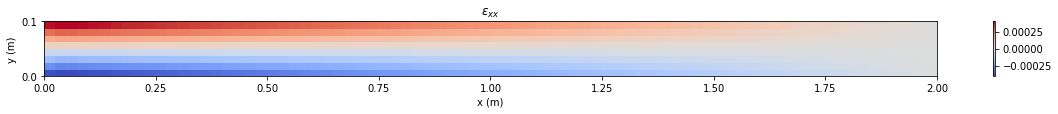

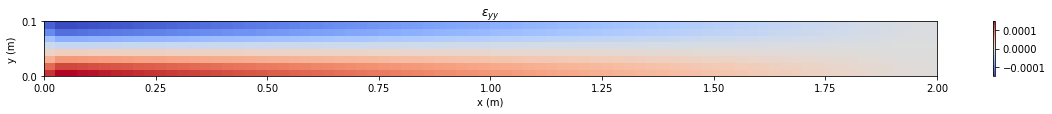

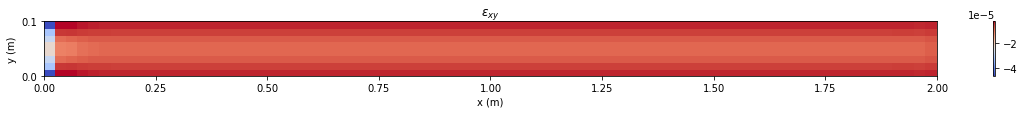

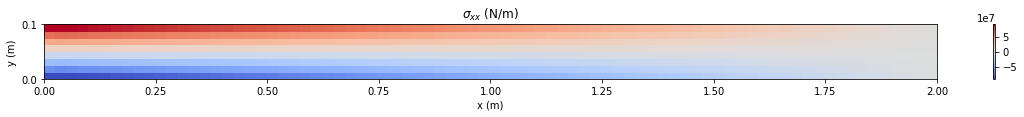

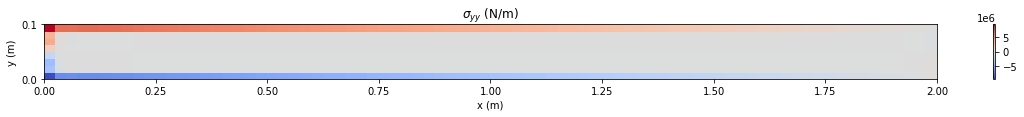

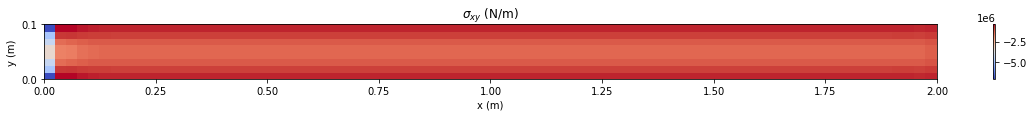

Beam tip deflection: -0.012639536742031953


In [75]:
filepath = 'Solution_examples/x_80_y_8/0'
nx, ny, Lx, Ly = 80, 8, 2, 0.1

postProcessing(filepath, nx, ny, Lx, Ly).yDeflection()
postProcessing(filepath, nx, ny, Lx, Ly).epsilonGraph()
postProcessing(filepath, nx, ny, Lx, Ly).sigmaGraph(mu_, lambda_)

y_deflection = np.min(postProcessing(filepath, nx, ny, Lx, Ly).v_with_boundaries)
deflection_array = np.append(deflection_array, [y_deflection])
nx_array = np.append(nx_array, nx)
print("Beam tip deflection: " + str(y_deflection))


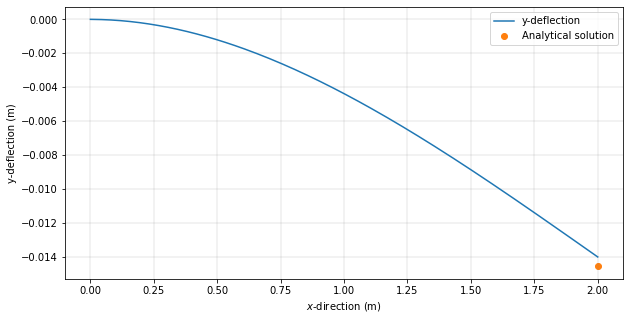

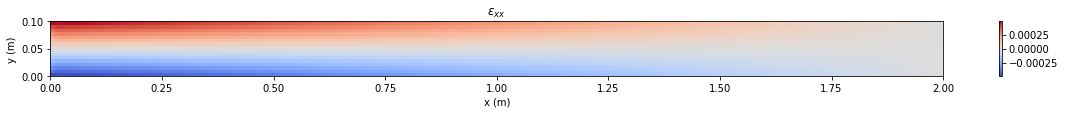

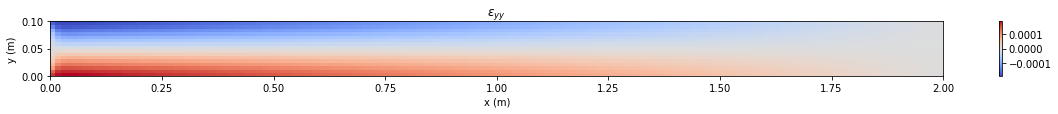

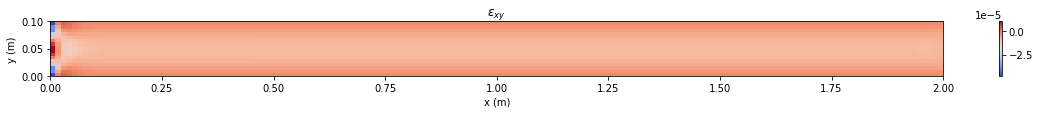

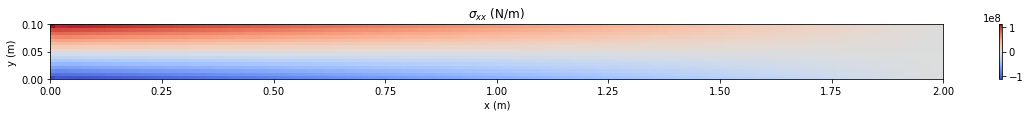

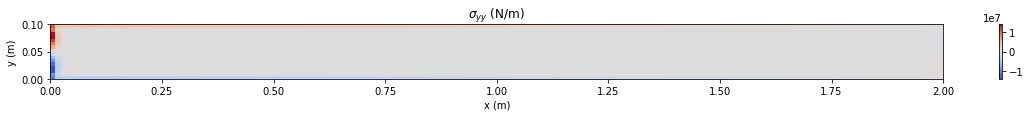

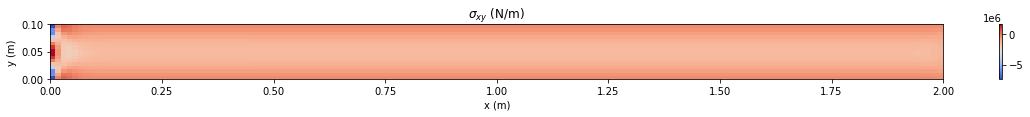

Beam tip deflection: -0.013999617795865815


In [76]:
filepath = 'Solution_examples/x_160_y_16/0'
nx, ny, Lx, Ly = 160, 16, 2, 0.1
postProcessing(filepath, nx, ny, Lx, Ly).yDeflection()
postProcessing(filepath, nx, ny, Lx, Ly).epsilonGraph()
postProcessing(filepath, nx, ny, Lx, Ly).sigmaGraph(mu_, lambda_)

y_deflection = np.min(postProcessing(filepath, nx, ny, Lx, Ly).v_with_boundaries)
deflection_array = np.append(deflection_array, [y_deflection])
nx_array = np.append(nx_array, nx)
print("Beam tip deflection: " + str(y_deflection))


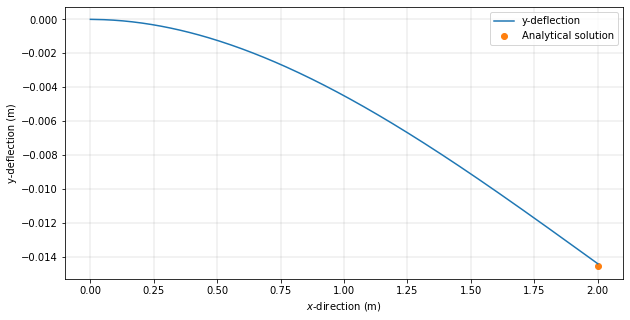

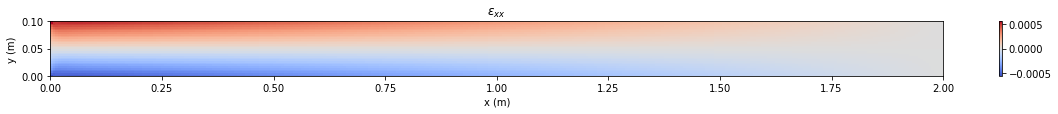

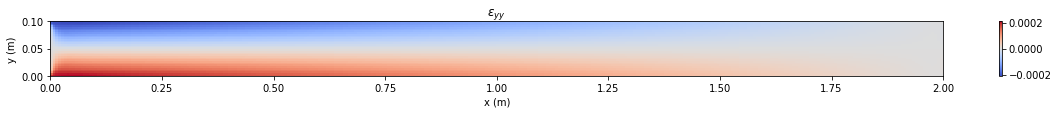

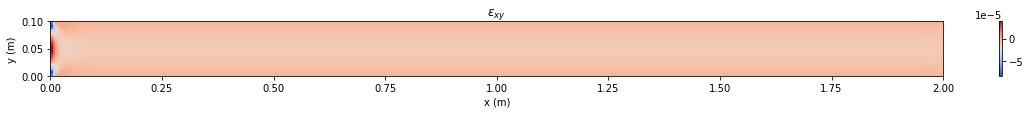

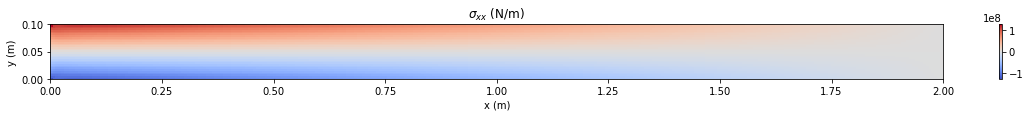

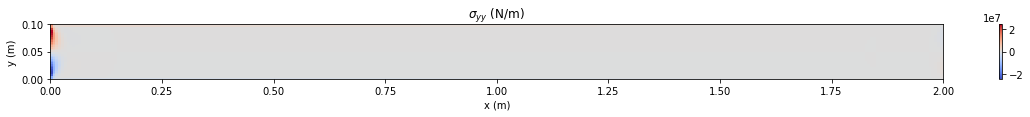

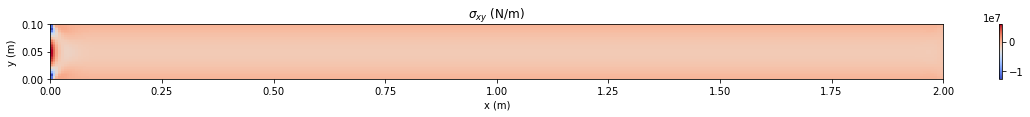

Beam tip deflection: -0.014396048562520046


In [77]:
filepath = 'Solution_examples/x_320_y_32/0'
nx, ny, Lx, Ly = 320, 32, 2, 0.1
postProcessing(filepath, nx, ny, Lx, Ly).yDeflection()
postProcessing(filepath, nx, ny, Lx, Ly).epsilonGraph()
postProcessing(filepath, nx, ny, Lx, Ly).sigmaGraph(mu_, lambda_)

y_deflection = np.min(postProcessing(filepath, nx, ny, Lx, Ly).v_with_boundaries)
deflection_array = np.append(deflection_array, [y_deflection])
nx_array = np.append(nx_array, nx)
print("Beam tip deflection: " + str(y_deflection))


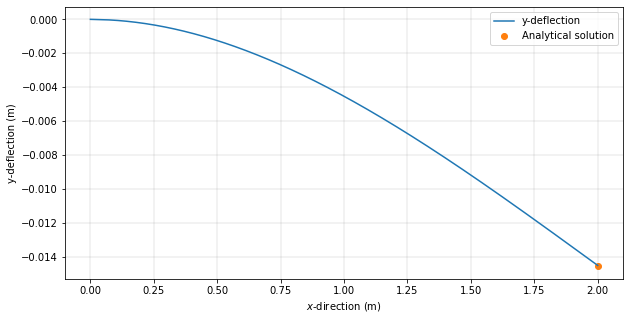

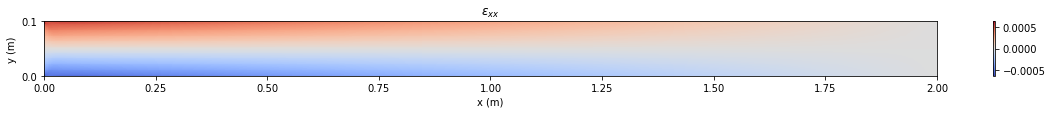

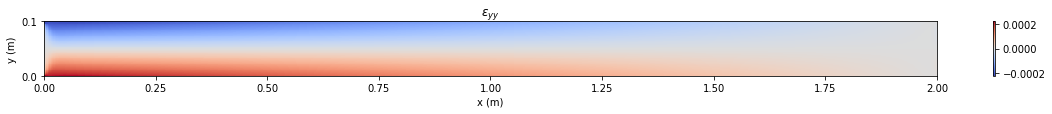

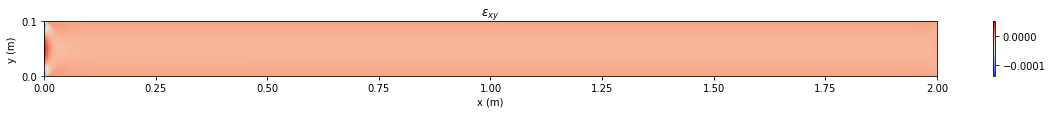

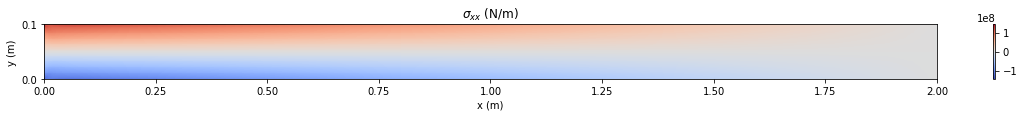

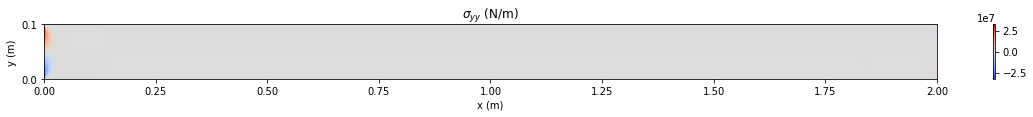

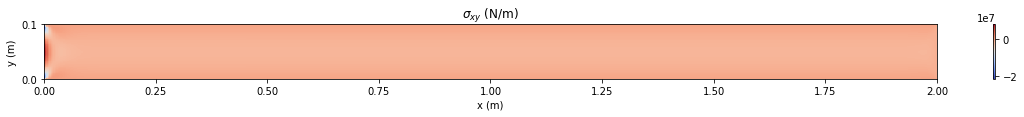

Beam tip deflection: -0.014499863422995944


In [78]:
filepath = '/home/scottlevie/newPythonSolver/migratetogithub/pythonFVSolidMechanics/extra/mesh-sensitivity/pythonSolver/x_640_y_64/1'
nx, ny, Lx, Ly = 640, 64, 2, 0.1
postProcessing(filepath, nx, ny, Lx, Ly).yDeflection()
postProcessing(filepath, nx, ny, Lx, Ly).epsilonGraph()
postProcessing(filepath, nx, ny, Lx, Ly).sigmaGraph(mu_, lambda_)

y_deflection = np.min(postProcessing(filepath, nx, ny, Lx, Ly).v_with_boundaries)
deflection_array = np.append(deflection_array, [y_deflection])
nx_array = np.append(nx_array, nx)
print("Beam tip deflection: " + str(y_deflection))


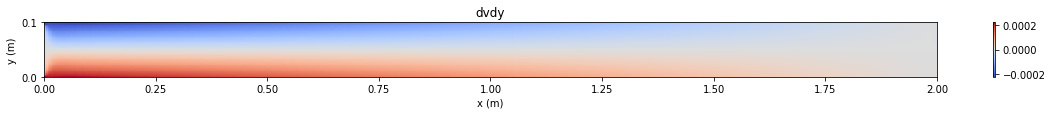

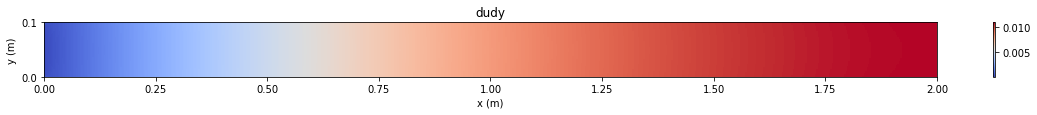

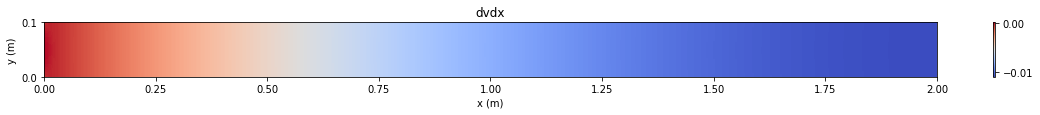

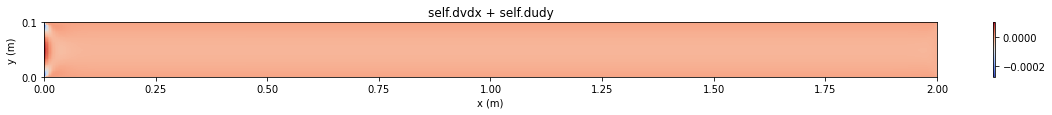

In [79]:
postProcessing(filepath, nx, ny, Lx, Ly).partialGraphs()

## Mesh refinement study


In [80]:
# Solver error and mesh spacing arrays
mesh_spacing = Lx/nx_array
mesh_spacing_640 =  Lx/nx_array_640

error = (-0.01456) - deflection_array
error_percentage = error/(-0.01456)

# solids4foam results
s4f = np.array((-0.0126095, -0.0139089, -0.0143407, -0.0144772, -0.0144608))
error_s4f = (-0.01456) - s4f
error_percentage_s4f = error_s4f/(-0.01456)

# solids4foam results
s4f_coupled = -0.0145365
error_s4f_coupled = (-0.01456) - s4f_coupled
error_percentage_s4f_coupled = error_s4f_coupled/(-0.01456)

# 2nd order slope
error_2 = 0.02
error_2nd_order = [error_2*4**4, error_2*4**3, error_2*4**2, error_2*4, error_2]

# 1st order slope
error_1 = 0.001
error_1st_order = [error_1*2**4, error_1*2**3, error_1*2**2, error_1*2, error_1]

NameError: name 'nx_array_640' is not defined

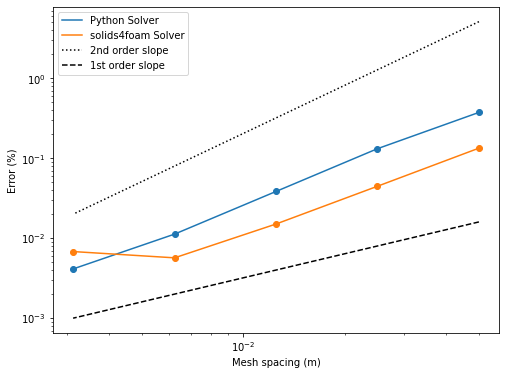

In [86]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = False
plt.scatter(mesh_spacing, error_percentage)
plt.plot(mesh_spacing, error_percentage, label = "Python Solver")
plt.plot(mesh_spacing, error_percentage_s4f, label = "solids4foam Solver")
plt.scatter(mesh_spacing, error_percentage_s4f)
# plt.scatter(mesh_spacing[-1], error_percentage_s4f_coupled, c = "C1", marker = "*", label = "solids4foam coupled solver")
plt.plot(mesh_spacing, error_2nd_order, label = "2nd order slope", c = "black", linestyle = ":")
plt.plot(mesh_spacing, error_1st_order, label = "1st order slope", c = "black", linestyle = "--")
plt.xlabel("Mesh spacing (m)")
plt.ylabel("Error (%)")
plt.xscale("log")
plt.yscale("log")
plt.legend()

Need to run 8- at tighter tolerance and see results.

In [ ]:
deflection_array 

array([-0.00909927, -0.01263954, -0.01399962, -0.01439605, -0.01449986])

In [ ]:
-0.00928324201415046

array([-0.0126095, -0.0139089, -0.0143407, -0.0144772, -0.0144608])

***
[<svg style="color: rgb(53, 145, 243);" xmlns="http://www.w3.org/2000/svg" width="20" height="20" fill="currentColor" class="bi bi-arrow-left-circle-fill" viewBox="0 0 16 16"> <path d="M8 0a8 8 0 1 0 0 16A8 8 0 0 0 8 0zm3.5 7.5a.5.5 0 0 1 0 1H5.707l2.147 2.146a.5.5 
0 0 1-.708.708l-3-3a.5.5 0 0 1 0-.708l3-3a.5.5 0 1 1 .708.708L5.707 7.5H11.5z" fill="#3591f3"></path> </svg> **Notebook 7** ](https://nbviewer.org/github/scottlevie97/pythonFVSolidMechanics/blob/new-release/lesson_notebooks/_07_Time_Loop.ipynb?flush_cache=true)

***